In [1]:
# reload notebook
%load_ext autoreload
%autoreload 2
import jax 
import sys 
sys.path.append("/scr/aliang80/changepoint_aug/changepoint_aug/density_estimation")
import pickle
import jax.numpy as jnp
import os
import haiku as hk
import matplotlib.animation as animation
from utils import load_maze_data
import pickle
import jax
import torch
import haiku as hk
import numpy as np
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from models import q_fn, vae_fn, decode_fn,  get_prior_fn
from functools import partial
from configs.vae_config import get_config as get_vae_config
from configs.bc_config import get_config as get_bc_config
from models import policy_fn
from pathlib import Path
from tensorflow_probability.substrates import jax as tfp

dist = tfp.distributions
os.environ['CUDA_VISIBLE_DEVICES'] = '6'


ImportError: cannot import name 'load_maze_data' from 'utils' (/scr/aliang80/changepoint_aug/changepoint_aug/density_estimation/utils.py)

In [51]:
# get arbitary config 
bc_config = get_bc_config()
rng_key = jax.random.PRNGKey(0)

data_file = os.path.join(bc_config.data_dir, "sac_maze_dense_reward_200_episodes.pkl")

# load trained q model

model_base = "/scr/aliang80/changepoint_aug/changepoint_aug/ray_results/2_bc/train_model_fn_0dfa2_00001_1_num_trajs=10_2024-03-03_20-10-17"
model_file = Path(model_base) / "model_ckpts" / "epoch_190.pkl"

with open(model_file, "rb") as f:
    params = pickle.load(f)

print("loading q model from", model_file)

# load dataset
dataset, train_dataloader, test_dataloader, obs_dim, action_dim = (
    load_maze_data(
        data_file,
        batch_size=bc_config.batch_size,
        num_trajs=500,
        train_perc=bc_config.train_perc
    )
)

loading q model from /scr/aliang80/changepoint_aug/changepoint_aug/ray_results/2_bc/train_model_fn_0dfa2_00001_1_num_trajs=10_2024-03-03_20-10-17/model_ckpts/epoch_190.pkl
number of rollouts:  200
average length of rollout:  310.295
obs_data shape:  torch.Size([61859, 6]) action_data shape:  torch.Size([61859, 2])
min obs data: torch.return_types.min(
values=tensor([-2.2135, -2.4461, -5.2254, -5.2262, -2.2330, -2.2267],
       dtype=torch.float64),
indices=tensor([22017, 24129, 33402,  8958,  3007, 22017])), max obs data: torch.return_types.max(
values=tensor([2.4332, 2.4417, 5.2260, 5.2398, 2.2458, 2.2462], dtype=torch.float64),
indices=tensor([10333, 10326, 42284, 26106, 12363, 29010]))
min action data: torch.return_types.min(
values=tensor([-0.9999, -1.0000]),
indices=tensor([11211, 48338])), max action data: torch.return_types.max(
values=tensor([0.9999, 0.9999]),
indices=tensor([27557, 42785]))
number of train batches:  434
number of test batches:  48


[    0   132  1242  1426  1671  1879  2041  2267  2396  2583  2691  2807
  3007  3169  3292  3494  3728  4830  4925  5046  5161  7266  8740  8973
  9085  9265  9494  9655  9790  9959 10074 10195 10468 10589 10722 10971
 11096 11242 11400 11581 11809 11898 12052 12223 12363 12611 12716 13886
 14137 14255 14401 15572 15733 15933 16034 17163 17374 17660 17875 18054
 18178 18398 18540 18670 19824 19956 20100 20246 20413 20733 21879 22017
 24133 24261 24381 24969 25072 25259 25460 25582 25721 25890 26018 26123
 26294 26415 26552 26681 26813 26947 27084 27228 27638 27865 29010 29123
 29327 30468 30613 31741 31878 31963 32079 32253 33365 33526 33728 33854
 34022 34151 34281 34423 34551 34632 35622 35770 36159 36294 37440 37544
 37757 37869 38010 38138 38242 39405 39523 39869 40089 41234 41337 41454
 41617 42371 42566 42750 42870 43039 43182 44307 45439 45638 45756 45889
 46003 46174 46309 46411 47663 47816 47971 48127 48338 49441 49601 49738
 49872 49986 50165 50275 50396 50743 50934 51869 53

/tmp/ipykernel_2350028/2426946358.py:111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = axes[4].scatter(all_obss[:, 0], all_obss[:, 1], cmap="viridis")
/tmp/ipykernel_2350028/2426946358.py:117: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = axes[5].scatter(all_obss[:, 0], all_obss[:, 1], cmap="viridis")


<Figure size 640x480 with 0 Axes>

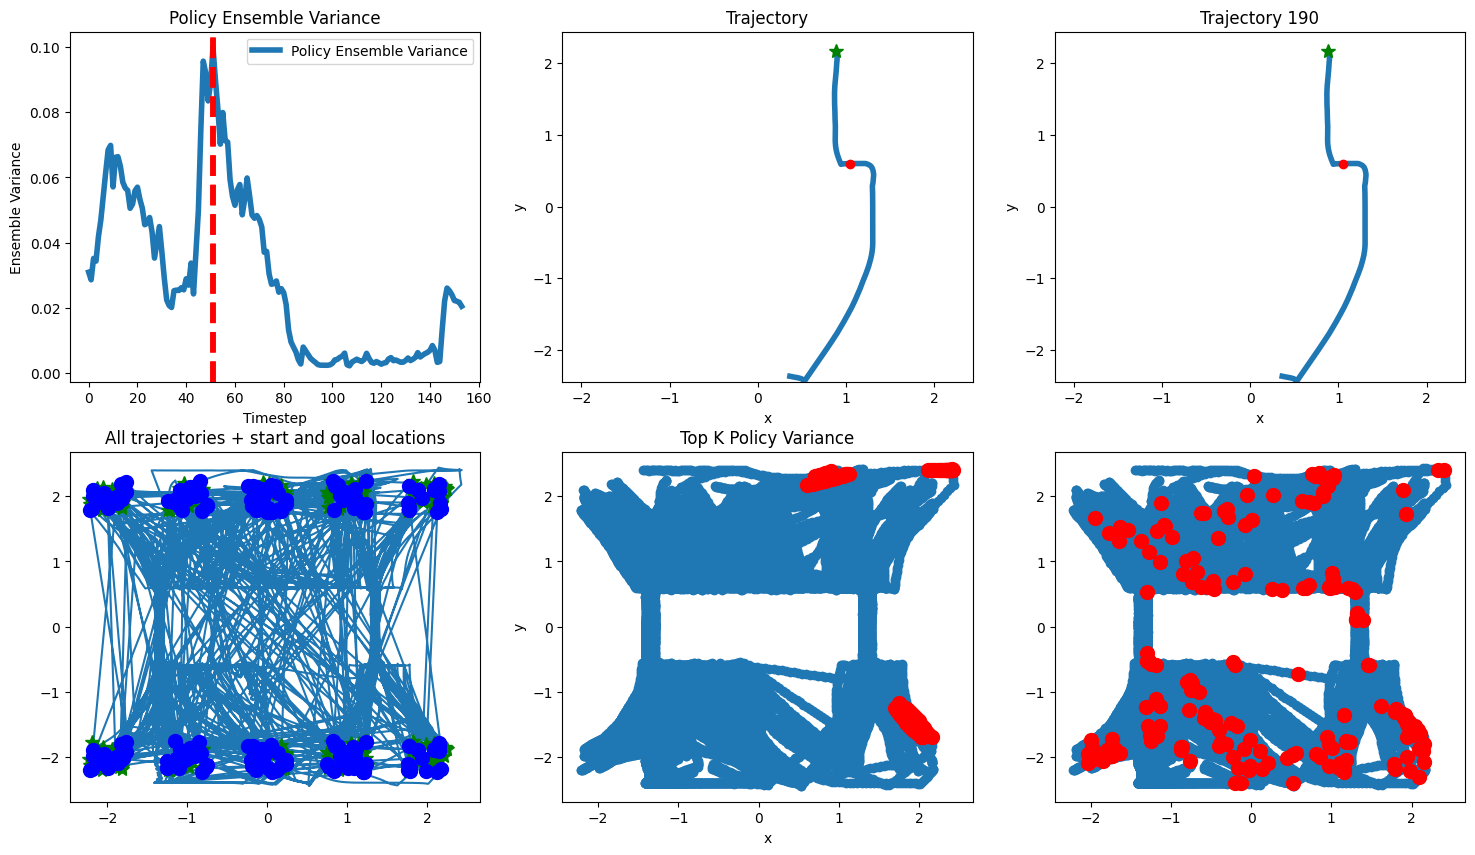

In [52]:
start_indices = np.where(dataset[:][-1])[0]
start_indices += 1
start_indices = np.insert(start_indices, 0, 0)
traj_indx = np.random.randint(0, len(start_indices) - 1)

start = start_indices[traj_indx]
end = start_indices[traj_indx + 1]

all_obss, all_actions, all_next_obss, all_next_actions, all_rewards, all_dones = dataset[:]

min_x = torch.min(all_obss[:, 0])
max_x = torch.max(all_obss[:, 0])
min_y = torch.min(all_obss[:, 1])
max_y = torch.max(all_obss[:, 1])

print(start_indices)

obss = all_obss[start:end].numpy()
actions = all_actions[start:end].numpy()
rewards = all_rewards[start:end].numpy()

print(obss.shape, actions.shape, rewards.shape)

T = np.arange(len(obss))
policy_apply = partial(
    jax.jit(policy_fn.apply, static_argnums=(3, 4)),
    hidden_size=bc_config.hidden_size,
    action_dim=2,
)
policy_rng_keys = jax.random.split(rng_key, bc_config.num_policies + 1)
action_preds = jax.vmap(lambda param, rng_key: policy_apply(param, rng_key, obss))(
    params, policy_rng_keys[1:]
)
# compute variance between ensemble
variance = jnp.var(action_preds, axis=0)

# compute mean over action dimension
variance = jnp.mean(variance, axis=-1)

plt.clf()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# first subplot plot the q_values and rewards
axes[0].plot(T, variance, label="Policy Ensemble Variance", linewidth=4)
axes[0].legend()
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("Ensemble Variance")
axes[0].set_title(f"Policy Ensemble Variance")

# plot the trajectory
traj_xy = obss[:, :2]
(traj_plot,) = axes[1].plot(traj_xy[:, 0], traj_xy[:, 1], linewidth=4)
goal = traj_xy[0][-2:]
axes[1].plot(goal[0], goal[1], "g*", markersize=10)
axes[1].set_xlim(min_x, max_x)
axes[1].set_ylim(min_y, max_y)
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].set_title(f"Trajectory")

# find location with max variance
max_var_idx = np.argmax(variance)
# set vline there
axes[0].axvline(x=max_var_idx, color="r", linestyle="--", linewidth=4)
max_var_point = obss[max_var_idx, :2]
axes[1].plot(max_var_point[0], max_var_point[1], "ro")


# plot the trajectory
traj_xy = obss[:, :2]
(traj_plot,) = axes[2].plot(traj_xy[:, 0], traj_xy[:, 1], linewidth=4)
axes[2].plot(goal[0], goal[1], "g*", markersize=10)
axes[2].set_xlim(min_x, max_x)
axes[2].set_ylim(min_y, max_y)
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")
axes[2].set_title(f"Trajectory {traj_indx}")

# find location with max variance
max_var_idx = np.argmax(variance)
# set vline there
axes[0].axvline(x=max_var_idx, color="r", linestyle="--", linewidth=4)
axes[1].axvline(x=max_var_idx, color="r", linestyle="--", linewidth=4)
# make a point in axes[2]
max_var_point = obss[max_var_idx, :2]
axes[2].plot(max_var_point[0], max_var_point[1], "ro")

# plot all of the trajectorie
all_obss = dataset[:][0].numpy()
all_goal_locations = all_obss[start_indices[:-1], -2:]
all_start_locations = all_obss[start_indices[:-1], :2]
axes[3].plot(all_obss[:, 0], all_obss[:, 1])
axes[3].plot(all_goal_locations[:, 0], all_goal_locations[:, 1], "g*", markersize=10)
axes[3].plot(all_start_locations[:, 0], all_start_locations[:, 1], "bo", markersize=10)
axes[3].set_title("All trajectories + start and goal locations")

policy_rng_keys = jax.random.split(rng_key, bc_config.num_policies + 1)
action_preds = jax.vmap(lambda param, rng_key: policy_apply(param, rng_key, all_obss))(
    params, policy_rng_keys[1:]
)
# compute variance between ensemble
variance = jnp.var(action_preds, axis=0)
variance = jnp.mean(variance, axis=-1)

# get top k points with max variance
k = 200
top_k_idx = jnp.argsort(variance)[-k:]
top_k_points = all_obss[top_k_idx, :2]

scat = axes[4].scatter(all_obss[:, 0], all_obss[:, 1], cmap="viridis")
axes[4].plot(top_k_points[:, 0], top_k_points[:, 1], "ro", markersize=10)
axes[4].set_title("Top K Policy Variance")
axes[4].set_xlabel("x")
axes[4].set_ylabel("y")

# scat = axes[5].scatter(all_obss[:, 0], all_obss[:, 1], cmap="viridis")

# # compute for each trajectory point with max variance
# print(len(range(len(start_indices) - 1)))
# for i in range(len(start_indices) - 1):
#     start = start_indices[i]
#     end = start_indices[i + 1]
#     obss = all_obss[start:end]

#     var = variance[start:end]
#     # print(var.shape)

#     # top k 
#     k = 1
#     top_k_idx = jnp.argsort(var)[-k:]
#     top_k_points = obss[top_k_idx, :2]
#     axes[5].plot(top_k_points[:, 0], top_k_points[:, 1], "ro", markersize=10)
# # axes[5].set_title("Trajectory with max variance")

In [ ]:
from collections import Counter
start_goal = all_obss[start_indices[:-1], -2:]
print(start_goal.shape)
Counter(start_goal.sum(axis=-1).tolist())
Counter(all_goal_locations.sum(axis=-1).tolist())

(100, 2)


Counter({0.21714340896865436: 999,
         4.308837197806755: 999,
         4.165924230834062: 999,
         1.958908693241645: 999,
         3.6730622004479376: 999,
         3.986351067352034: 999,
         4.135198212828259: 999,
         0.1346858664346735: 999,
         1.9682568325571312: 999,
         4.288305885045938: 600,
         4.410267337047719: 570,
         4.231309871976576: 490,
         3.6882585979758913: 477,
         4.048842200516791: 414,
         3.8733769614702416: 396,
         2.0281928253277424: 308,
         1.8073716783485634: 277,
         2.7781830932591616: 269,
         2.9925080073988672: 269,
         2.076058121131373: 229,
         1.1518863334461238: 223,
         1.6754330461069542: 217,
         1.1455363399461267: 209,
         1.9334255986112687: 209,
         0.6089973690138797: 206,
         0.8471553086870259: 204,
         1.914158999686661: 202,
         -0.3022329229412044: 200,
         -0.1101372449791298: 199,
         1.84286740624

In [51]:
vl_1 = ax1.axvline(x=0)
vl_2 = ax2.axvline(x=0)

def animate(i):
    vl_1.set_xdata([i, i])
    vl_2.set_xdata([i, i])
    traj_plot.set_data(xy[:i, 0], xy[:i, 1])

print("saving anim")
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

ani = animation.FuncAnimation(fig, animate, frames=T, interval=10, blit=True)
ani.save("movie.gif", fps=30, writer='imagemagick')

# %matplotlib notebook
# from IPython.display import HTML
# HTML(ani.to_jshtml())

MovieWriter imagemagick unavailable; using Pillow instead.


saving anim
